## This notebook is part of Hadoop and Spark training delivered by IT-DB group
### SPARK RDD Hands-On Lab
_ by Prasanth Kothuri _

### Hands-On 1 - Load and inspect the data from HDFS

#### Please execute the following steps if you are running in Spark local mode
*SPARK context must be explicity created in local mode*

In [1]:
from pyspark import SparkContext

In [2]:
sc = SparkContext()

#### Run the following cell to create an rdd containing the UN Pop Stats data

In [3]:
rdd = sc.textFile("../data/UN_Pop_Stats.csv.gz")

#### Lets see if the rdd contains any data; take(n) - returns the first n elements of the RDD

In [4]:
rdd.take(5)

[u'LocID,Location,VarID,Variant,Time,MidPeriod,SexID,Sex,AgeGrp,AgeGrpStart,AgeGrpSpan,Value',
 u'4,"Afghanistan",2,"Medium","1950",1950.5,1,"Male","0-4",0,5,630.044',
 u'4,"Afghanistan",2,"Medium","1950",1950.5,1,"Male","5-9",5,5,516.205',
 u'4,"Afghanistan",2,"Medium","1950",1950.5,1,"Male","10-14",10,5,461.378',
 u'4,"Afghanistan",2,"Medium","1950",1950.5,1,"Male","15-19",15,5,414.368']

#### oops, there is a header, lets remove it first

In [5]:
headless_rdd = rdd.filter(lambda line: 'LocID' not in line)

#### inspect the data to see if the header is still present

In [6]:
headless_rdd.take(5)

[u'4,"Afghanistan",2,"Medium","1950",1950.5,1,"Male","0-4",0,5,630.044',
 u'4,"Afghanistan",2,"Medium","1950",1950.5,1,"Male","5-9",5,5,516.205',
 u'4,"Afghanistan",2,"Medium","1950",1950.5,1,"Male","10-14",10,5,461.378',
 u'4,"Afghanistan",2,"Medium","1950",1950.5,1,"Male","15-19",15,5,414.368',
 u'4,"Afghanistan",2,"Medium","1950",1950.5,1,"Male","20-24",20,5,374.110']

### Hands-On 2 - Convert headless_rdd to an RDD containing python namedtuple objects

#### Lets import couple of things we need

In [7]:
from collections import namedtuple
from pprint import pprint

#### schema for the namedtuple
*Named tuples are tuples that allow their elements to be accessed by name instead of just index*

In [8]:
pData = namedtuple('pData',['LocID','Location','VarID','Variant','Time','MidPeriod','SexID','Sex','AgeGrp','AgeGrpStart','AgeGrpSpan','Value'])

#### Function to map the data

In [9]:
def map_record(record):
  columns = record.split(",")[:12]
  return pData(*columns)

#### The following map created new python namedtuple rdd

In [10]:
ntuple_rdd = headless_rdd.map(map_record)

#### Inspect the data

In [11]:
ntuple_rdd.take(5)

[pData(LocID=u'4', Location=u'"Afghanistan"', VarID=u'2', Variant=u'"Medium"', Time=u'"1950"', MidPeriod=u'1950.5', SexID=u'1', Sex=u'"Male"', AgeGrp=u'"0-4"', AgeGrpStart=u'0', AgeGrpSpan=u'5', Value=u'630.044'),
 pData(LocID=u'4', Location=u'"Afghanistan"', VarID=u'2', Variant=u'"Medium"', Time=u'"1950"', MidPeriod=u'1950.5', SexID=u'1', Sex=u'"Male"', AgeGrp=u'"5-9"', AgeGrpStart=u'5', AgeGrpSpan=u'5', Value=u'516.205'),
 pData(LocID=u'4', Location=u'"Afghanistan"', VarID=u'2', Variant=u'"Medium"', Time=u'"1950"', MidPeriod=u'1950.5', SexID=u'1', Sex=u'"Male"', AgeGrp=u'"10-14"', AgeGrpStart=u'10', AgeGrpSpan=u'5', Value=u'461.378'),
 pData(LocID=u'4', Location=u'"Afghanistan"', VarID=u'2', Variant=u'"Medium"', Time=u'"1950"', MidPeriod=u'1950.5', SexID=u'1', Sex=u'"Male"', AgeGrp=u'"15-19"', AgeGrpStart=u'15', AgeGrpSpan=u'5', Value=u'414.368'),
 pData(LocID=u'4', Location=u'"Afghanistan"', VarID=u'2', Variant=u'"Medium"', Time=u'"1950"', MidPeriod=u'1950.5', SexID=u'1', Sex=u'"Mal

### Hands-On 3 - Aggregate the population by Age Group for Switzerland for 2015
*This introduces filter, map, reduceByKey transformations and collect actions*

In [12]:
plot_rdd = ntuple_rdd.filter(lambda record: record.Location =='"Switzerland"' and record.Time == '"2015"' and record.Sex in ['"Male"','"Female"']) \
    .map(lambda record: (int(record.AgeGrpStart),int(float(record.Value)*1000))) \
    .reduceByKey(lambda x,y: x+y) \
    .sortByKey() \
    .collect()

#### Lets draw the population distribution histogram

In [13]:
%matplotlib notebook
import matplotlib.pyplot as plt

<IPython.core.display.Javascript object>


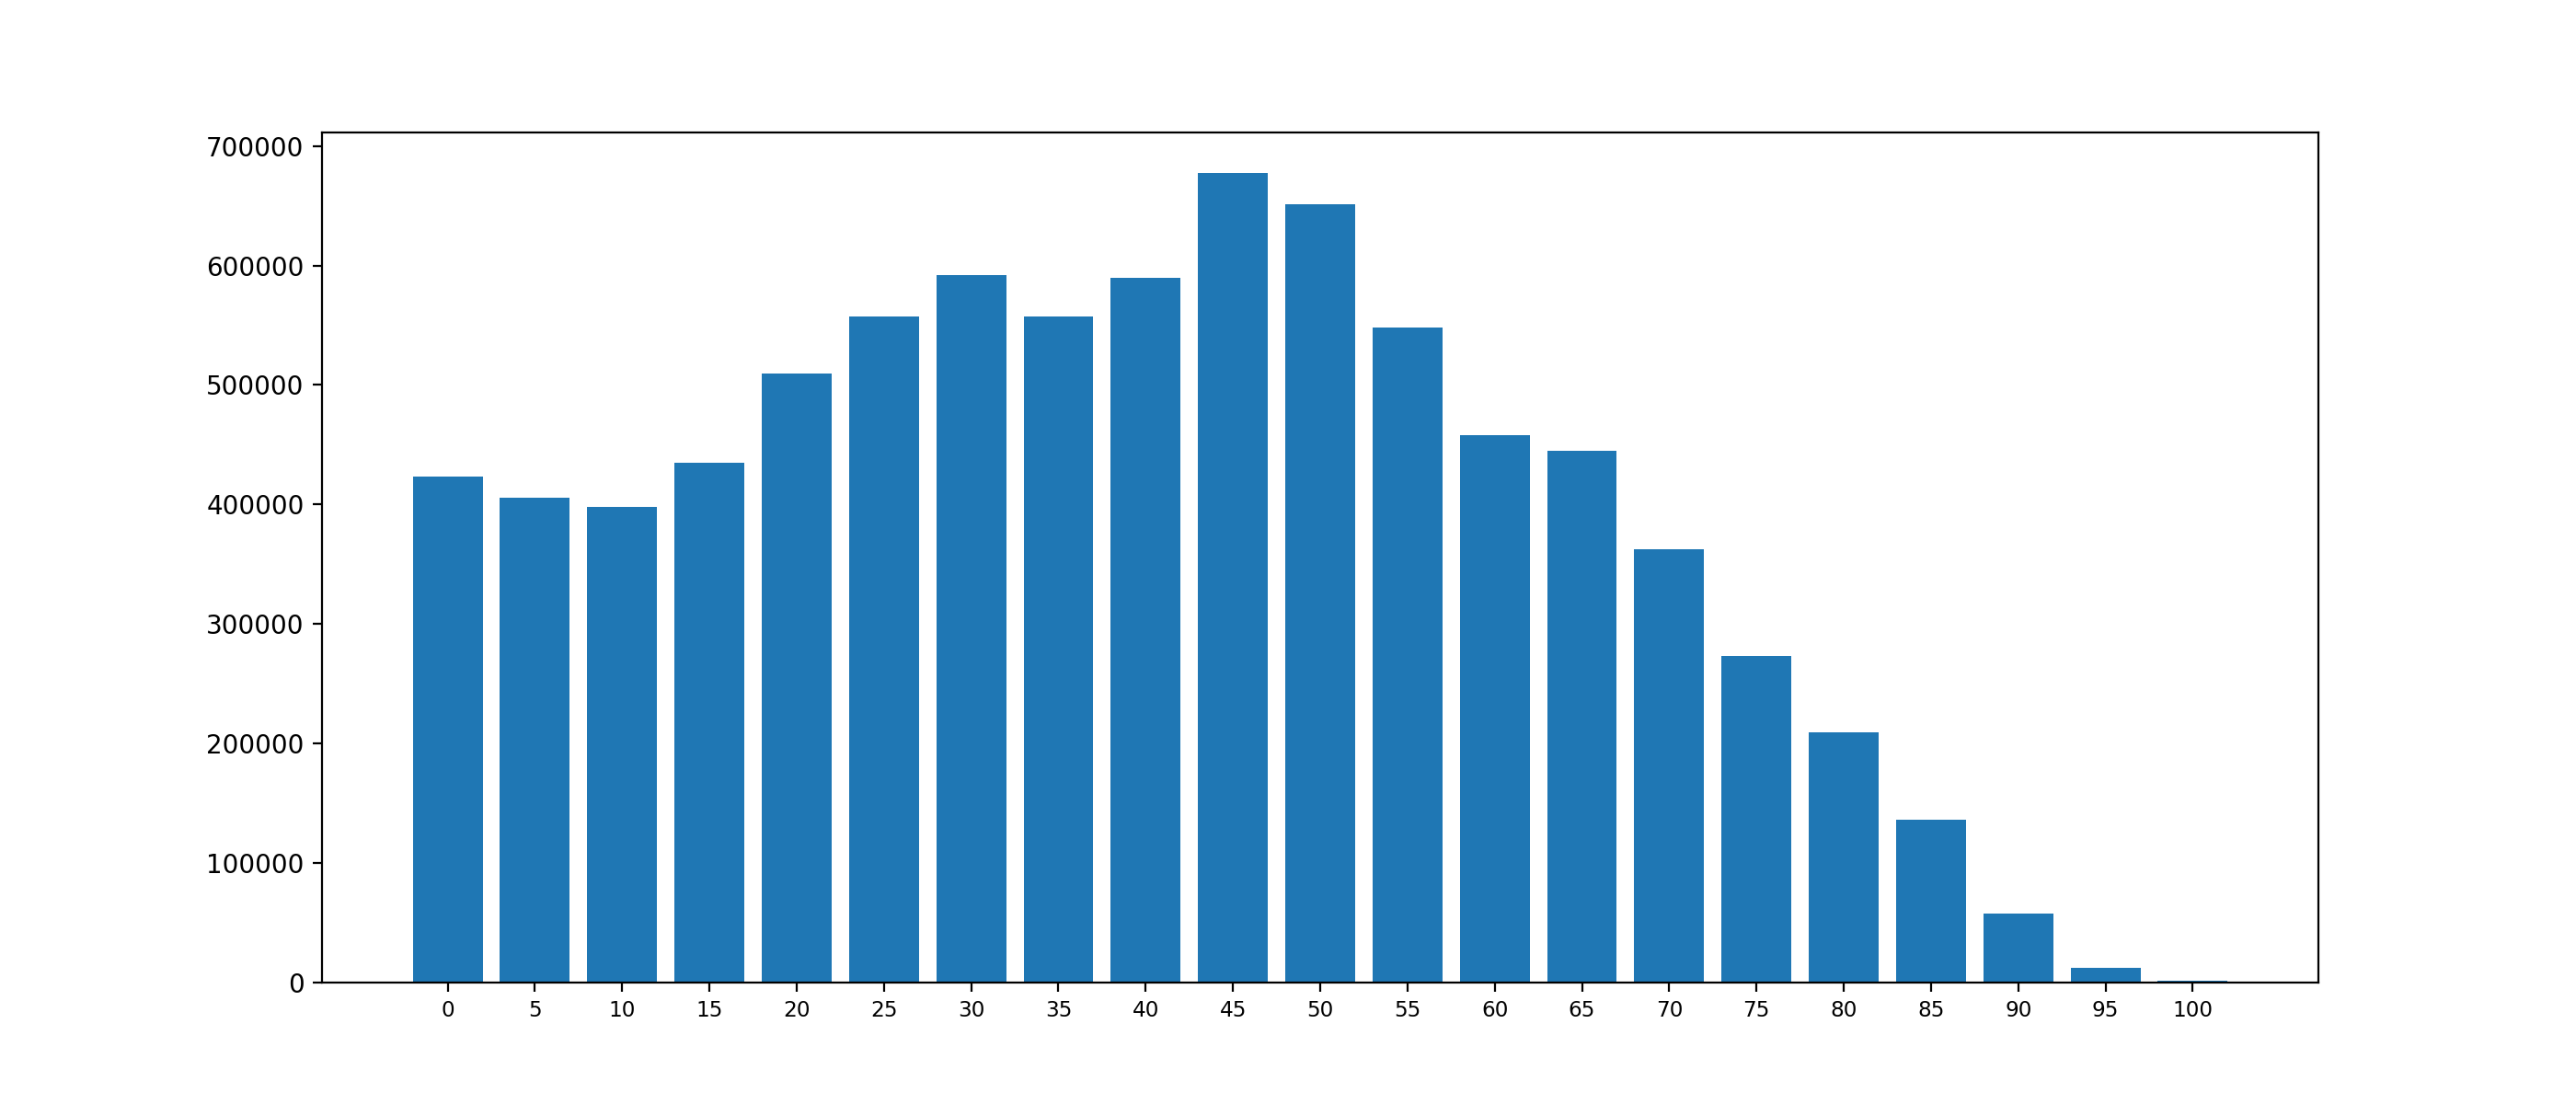

[(0, 423175), (5, 405366), (10, 397616), (15, 435016), (20, 509516), (25, 557227), (30, 591613), (35, 557624), (40, 589307), (45, 677384), (50, 651470), (55, 548059), (60, 458058), (65, 445100), (70, 362208), (75, 273224), (80, 209059), (85, 136121), (90, 57859), (95, 12047), (100, 1614)]


In [14]:
plt.figure(figsize=(14,6))
x_val = [x[0] for x in sorted(plot_rdd)]
y_val = [x[1] for x in sorted(plot_rdd)]
print plot_rdd
plt.bar(range(len(y_val)), y_val)
plt.xticks(range(len(x_val)), x_val, size='small')
plt.show()

### Exercise 1 - show the centenarian populations by country for 2015 ordered by values in the decending order 
*Hint - this requires use of filter, map, reduceByKey and sortByKey*

In [15]:
# %load key/solution1.py
ntuple_rdd.filter(lambda record: record.AgeGrp =='"100+"' and record.Time == '"2015"' and record.Sex == '"Both"') \
    .map(lambda record: (record.Location,int(float(record.Value)*1000))) \
    .reduceByKey(lambda x,y: x+y) \
    .map(lambda (x,y):(y,x)).sortByKey(False) \
    .collect() \


[(450895, u'"WORLD"'),
 (265497, u'"More developed regions"'),
 (188964, u'"ASIA"'),
 (185398, u'"Less developed regions"'),
 (120820, u'"EUROPE"'),
 (116299, u'"Eastern Asia"'),
 (79724, u'"NORTHERN AMERICA"'),
 (71972, u'"United States of America"'),
 (60630, u'"Japan"'),
 (52418, u'"LATIN AMERICA AND THE CARIBBEAN"'),
 (47657, u'"China"'),
 (43016, u'"Western Europe"'),
 (40113, u'"Southern Europe"'),
 (37957, u'"South-Central Asia"'),
 (35490, u'"Southern Asia"'),
 (30926, u'"South-Eastern Asia"'),
 (29501, u'"South America"'),
 (27266, u'"India"'),
 (24592, u'"Italy"'),
 (23838, u'"Viet Nam"'),
 (21103, u'"Northern Europe"'),
 (19768, u'"France"'),
 (16588, u'"Eastern Europe"'),
 (16227, u'"United Kingdom"'),
 (16096, u'"Germany"'),
 (13556, u'"Central America"'),
 (11090, u'"Mexico"'),
 (9860, u'"Spain"'),
 (9361, u'"Caribbean"'),
 (7739, u'"Canada"'),
 (7629, u'"Least developed countries"'),
 (6077, u'"Brazil"'),
 (5956, u'"Argentina"'),
 (5733, u'"Bangladesh"'),
 (5586, u'"Chil

### Hands-On 4 - Convert the ntuple_rdd to DataFrame and save the DF as parquet file

#### Create sqlContext
*This is only required if you are running in SPARK local mode*

In [16]:
from pyspark import SQLContext

In [17]:
sqlContext = SQLContext(sc)

#### Convert RDD to DF and inspect the data

In [18]:
df = ntuple_rdd.toDF()

In [19]:
df.show()

+-----+-------------+-----+--------+------+---------+-----+--------+-------+-----------+----------+-------+
|LocID|     Location|VarID| Variant|  Time|MidPeriod|SexID|     Sex| AgeGrp|AgeGrpStart|AgeGrpSpan|  Value|
+-----+-------------+-----+--------+------+---------+-----+--------+-------+-----------+----------+-------+
|    4|"Afghanistan"|    2|"Medium"|"1950"|   1950.5|    1|  "Male"|  "0-4"|          0|         5|630.044|
|    4|"Afghanistan"|    2|"Medium"|"1950"|   1950.5|    1|  "Male"|  "5-9"|          5|         5|516.205|
|    4|"Afghanistan"|    2|"Medium"|"1950"|   1950.5|    1|  "Male"|"10-14"|         10|         5|461.378|
|    4|"Afghanistan"|    2|"Medium"|"1950"|   1950.5|    1|  "Male"|"15-19"|         15|         5|414.368|
|    4|"Afghanistan"|    2|"Medium"|"1950"|   1950.5|    1|  "Male"|"20-24"|         20|         5|374.110|
|    4|"Afghanistan"|    2|"Medium"|"1950"|   1950.5|    1|  "Male"|"25-29"|         25|         5|321.312|
|    4|"Afghanistan"|    2|"